In [1]:
%matplotlib inline

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import re
from html.parser import HTMLParser
from bs4 import BeautifulSoup


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
pd. set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 0)

In [3]:
alphavantage_csv_path = "/app/StockPricePredictions/data/alphavantage/time_series_daily_adjusted/AAPL/AAPL.csv"

In [4]:
df = pd.read_csv(alphavantage_csv_path, low_memory=False)
df.sort_values(by=["date"], ascending=True, inplace=True)

df = df[df["date"]>='2010-01-01']

df["date"] = pd.to_datetime(df['date'])

df.set_index("date", inplace=True)

In [5]:
df.shape[0]

3064

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3064 entries, 2010-01-04 to 2022-03-04
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   1. open               3064 non-null   float64
 1   2. high               3064 non-null   float64
 2   3. low                3064 non-null   float64
 3   4. close              3064 non-null   float64
 4   5. adjusted close     3064 non-null   float64
 5   6. volume             3064 non-null   float64
 6   7. dividend amount    3064 non-null   float64
 7   8. split coefficient  3064 non-null   float64
dtypes: float64(8)
memory usage: 215.4 KB


In [7]:
df.head(1)

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
date,,,,,,,,
2010-01-04,213.43,214.5,212.38,214.01,6.543876,17633200.0,0.0,1.0


In [8]:
benzinga_csv_path = "/app/StockPricePredictions/data/benzinga/aapl_non_dupes.csv"

In [9]:
df_benzinga = pd.read_csv(benzinga_csv_path, low_memory=False)

In [10]:
df_benzinga.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29077 entries, 0 to 29076
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      29077 non-null  object
 1   author    29077 non-null  object
 2   created   29077 non-null  object
 3   updated   29077 non-null  object
 4   title     29077 non-null  object
 5   teaser    4824 non-null   object
 6   body      23916 non-null  object
 7   url       29077 non-null  object
 8   image     29077 non-null  object
 9   channels  29077 non-null  object
 10  stocks    29077 non-null  object
 11  tags      29077 non-null  object
 12  AAPL      29077 non-null  bool  
 13  MSFT      29077 non-null  bool  
 14  AMZN      29077 non-null  bool  
 15  FB        29077 non-null  bool  
 16  NVDA      29077 non-null  bool  
 17  INTC      29077 non-null  bool  
 18  NFLX      29077 non-null  bool  
dtypes: bool(7), object(12)
memory usage: 2.9+ MB


In [11]:
df_benzinga.head(2)

,date,author,created,updated,title,teaser,body,url,image,channels,stocks,tags,AAPL,MSFT,AMZN,FB,NVDA,INTC,NFLX
0,2010-01-02,Benzinga,"Sat, 02 Jan 2010 22:47:49 -0400","Mon, 04 Jan 2010 17:23:32 -0400",Time to Sell Apple Puts,NaN,"In case you missed the meteoric run in Apple (NASDAQ: <a class=""ticker"" href=""/stock/aapl#NASDAQ"">AAPL</a>) over the last several months, there may still be a way to profit without having to chase the stock at these lofty levels: selling puts. When you sell puts you in a sense become an insurance salesman. You agree to buy the stock at some point in the future, should the stock fall to that level or lower before a given date. For this agreement, you receive a premium up front.\r\n\r\nWith Apple currently trading at $210/share, just off its 52-week high, I propose selling out-of-the-money puts for April or July. The April $190 contract bids at $8.15 and the July $180 contract bids at $10.25. \r\n\r\nI chose such long-dated contracts for their healty premiums. Just a reminder that the first rule of thumb with selling puts is to only sell puts on a stock you would be willing to own. Since I firmly believe in Apple's fundamentals and future business prospects, I would willingly buy the stock at $190 in April. However, nothing is certain, and Apple shares currently have a lot of positive news already ""baked in"". \r\n\r\nIf the upcoming tablet is a flop or never arrives at all, or if the company somehow misses earnings forecasts, the stock price may fall sharply. Since I agree with most analysts that Apple will earn roughly $11-12 in non-GAAP EPS in FY2010 and that a $240-260 price target is reasonable, selling out-of-the-money puts appears to be a great way to generate income and set the price you would be willing to pay for Apple shares. Therefore, it is my bet that Apple will stay above $190 by April and $180 by July and the put options will expire worthless, giving the seller a nice premium for either contract.",https://www.benzinga.com/node/74385,[],"[{'name': 'Long Ideas'}, {'name': 'Upgrades'}, {'name': 'Rumors'}, {'name': 'Price Target'}, {'name': 'Options'}, {'name': 'Markets'}, {'name': 'Analyst Ratings'}, {'name': 'Tech'}, {'name': 'Trading Ideas'}]",[{'name': 'AAPL'}],[{'name': 'Steve Jobs'}],True,False,False,False,False,False,False
1,2010-01-04,Benzinga,"Mon, 04 Jan 2010 09:45:06 -0400","Mon, 04 Jan 2010 12:31:34 -0400","Nexus – Will It Change Telecom Industry Dynamics? (GOOG, AAPL, RIMM, ATT, VZ)",NaN,"Google’s (NASDAQ: <a class=""ticker"" href=""/stock/goog#NASDAQ"">GOOG</a>) much awaited smartphone offering Nexus may hurt telecom service providers more than competitors like Apple (NASDAQ: <a class=""ticker"" href=""/stock/aapl#NASDAQ"">AAPL</a>) and Blackberry(NASDAQ: <a class=""ticker"" href=""/stock/rimm#NASDAQ"">RIMM</a>). \r\n\r\nTraditionally, offerings like iPhone were sold locked. i.e. you could use them only with a specified telecom carrier like AT&T (NYSE: <a class=""ticker"" href=""/stock/t#NYSE"">T</a>) or Verizon (NYSE: <a class=""ticker"" href=""/stock/vz#NYSE"">VZ</a>). However, according to industry sources, Google may introduce unlocked versions of the Nexus, thus heralding a paradigm shift in the dynamics of the telecom industry.",https://www.benzinga.com/node/74734,[],"[{'name': 'Earnings'}, {'name': 'News'}, {'name': 'Markets'}]","[{'name': 'AAPL'}, {'name': 'GOOG'}, {'name': 'RIMM'}, {'name': 'T'}, {'name': 'VZ'}]",[],True,False,False,False,False,False,False


In [12]:
df_benzinga["body"] = df_benzinga["body"].replace(np.nan, "")

In [13]:
def clean_text(text):
    soup = BeautifulSoup(text)

    # remove HTML tables
    for table in soup.find_all("table"):
        table.extract()

    text_without_tables = soup.text

    pattern1 = re.compile(r"\s")

    clean_text1 = re.sub(pattern1, " ", text_without_tables)

    pattern2 = re.compile(r"\\r|\\+n")

    clean_text2 = re.sub(pattern1, " ", clean_text1)

    clean_text3 = re.sub(r'^https?:\/\/.*[\r\n]*', '', clean_text2, flags=re.MULTILINE)

    return clean_text3

    
    

In [14]:
df_benzinga["body"] = df_benzinga["body"].apply(clean_text)

/root/.local/lib/python3.8/site-packages/bs4/__init__.py:431: MarkupResemblesLocatorWarning: "http://www.burstly.com/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/root/.local/lib/python3.8/site-packages/bs4/__init__.py:431: MarkupResemblesLocatorWarning: "http://www.engadget.com/2014/05/09/apple-just-hired-nokias-pureview-camera-expert/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(
/root/.local/lib/python3.8/site-packages/bs4/__init__.py:431: MarkupResemblesLocatorWarning: "http://gigaom.com/2014/05/30/powered-by-pano-focused-on-gaming-google-to-announce-android-tv-at-google-io-in-june/" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HT

In [15]:
df_benzinga["body"] = df_benzinga["body"].replace(np.nan, "")

In [16]:
df_benzinga["text"] = df_benzinga["title"] + " " + df_benzinga["body"]

In [17]:
df_benzinga['date'] = pd.to_datetime(df_benzinga['date'])

In [18]:
df_benzinga.set_index("date", inplace=True)

In [19]:
df_benzinga = df_benzinga[["text"]]

In [20]:
def remove_ticker(text):

    clean_text1 = re.sub(r'\(NASDAQ\s?:\s?\w+\)', '', text, flags=re.MULTILINE)

    clean_text2 = re.sub(r'\(NYSE\s?:\s?\w+\)', '', clean_text1, flags=re.MULTILINE)

    return clean_text2


In [21]:
df_benzinga["text"] = df_benzinga["text"].apply(remove_ticker)

In [22]:
benzinga_csv_out_path = "/app/StockPricePredictions/data/benzinga/aapl_non_dupes_text_only.csv"

In [23]:
# df_benzinga.to_csv(benzinga_csv_out_path)
df_benzinga2 = pd.read_csv(benzinga_csv_out_path)


In [24]:
df_benzinga2.head()

,date,text
0,2010-01-02,"Time to Sell Apple Puts In case you missed the meteoric run in Apple over the last several months, there may still be a way to profit without having to chase the stock at these lofty levels: selling puts. When you sell puts you in a sense become an insurance salesman. You agree to buy the stock at some point in the future, should the stock fall to that level or lower before a given date. For this agreement, you receive a premium up front. With Apple currently trading at $210/share, just off its 52-week high, I propose selling out-of-the-money puts for April or July. The April $190 contract bids at $8.15 and the July $180 contract bids at $10.25. I chose such long-dated contracts for their healty premiums. Just a reminder that the first rule of thumb with selling puts is to only sell puts on a stock you would be willing to own. Since I firmly believe in Apple's fundamentals and future business prospects, I would willingly buy the stock at $190 in April. However, nothing is certain, and Apple shares currently have a lot of positive news already ""baked in"". If the upcoming tablet is a flop or never arrives at all, or if the company somehow misses earnings forecasts, the stock price may fall sharply. Since I agree with most analysts that Apple will earn roughly $11-12 in non-GAAP EPS in FY2010 and that a $240-260 price target is reasonable, selling out-of-the-money puts appears to be a great way to generate income and set the price you would be willing to pay for Apple shares. Therefore, it is my bet that Apple will stay above $190 by April and $180 by July and the put options will expire worthless, giving the seller a nice premium for either contract."
1,2010-01-04,"Nexus – Will It Change Telecom Industry Dynamics? (GOOG, AAPL, RIMM, ATT, VZ) Google’s much awaited smartphone offering Nexus may hurt telecom service providers more than competitors like Apple and Blackberry. Traditionally, offerings like iPhone were sold locked. i.e. you could use them only with a specified telecom carrier like AT&T or Verizon . However, according to industry sources, Google may introduce unlocked versions of the Nexus, thus heralding a paradigm shift in the dynamics of the telecom industry."
2,2010-01-04,"Company News for January 04, 2010 - Corporate Summary • European shares are up on merger news. Novartis took steps to acquire the rest of Alcon from Nestle for $28.1 billion, noting intentions to purchase the remaining shares • Media reports said Kraft Foods will raise its hostile bid for Cadbury . Some reports also suggested Ferrero has talked with private equity companies and Hershey about a counter-offer • November semiconductor sales improved 8.5% to $22.6 billion • Google's Nexus One smartphone is rumored to be announced on January 5 • Apple's tablet computer is speculated for a January 26 release with an estimated price target of $1000 and 10 million slated for shipment • News Corp. and Time Warner reached a deal to maintain Fox on the air • Chesapeake Energy signed an agreement to sell its 25% stake in Barnett shale gas assets to Total for $2.25 billionZacks Investment Research"
3,2010-01-04,"Technology Industry Update (DELL, AAPL, AMD, INTC, NVD) Oppenheimer has released its latest report on the Technology/Semiconductor and Components industry. According to the report, customers of Dell Inc. are furious over the delay in holiday orders. Dell’s PC shipment woes have carried on past Christmas according to the report. Customers have shown their displeasure at the delayed shipments on the Direct2Dell blog and Twitter. Meanwhile the iPhone grapevine suggests that Apple Inc. is working to add support for the faster 802.11n WiFi standard in Apple's next iPhone, according to the report. Analysts at Oppenheimer meanwhile have a Perform rating for Advanced Micro Devices Inc. and an Outperform rating for Intel Corporation and NVIDIA Corporation ."
4,2010-01-04,"Apple Defies Gravity Apple aficionados have been waiting for th

In [25]:
# import spacy

In [26]:
# nlp = spacy.load('en_core_web_md')
# myvals = df_benzinga['text'].values.tolist()

In [27]:
# df_benzinga['len'] = df_benzinga['text'].str.split().str.len()

In [28]:
# df_benzinga.describe()

In [31]:
seq_len = df_benzinga["text"].apply(lambda x: len(x.split()))

In [39]:
seq_len.describe()

count    29077.000000
mean     274.873027  
std      373.246920  
min      2.000000    
25%      21.000000   
50%      186.000000  
75%      390.000000  
max      8491.000000 
Name: text, dtype: float64

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

<Figure size 1728x1152 with 0 Axes>

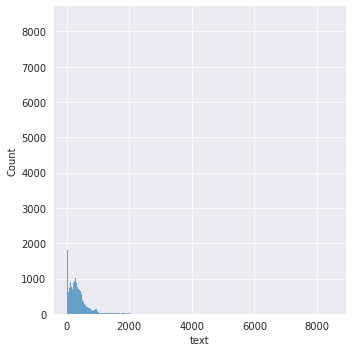

In [49]:
sns.set_style('darkgrid')
a = 2000
plt.figure(figsize=(24,16))
sns.displot(seq_len)